In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
supply_data= pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')
supply_data['Date'] = pd.to_datetime(supply_data['Date'])
supply_data = supply_data.sort_values('Date')
supply_data['Supply'] = supply_data['Supply'].str.replace(',', '').astype(float)

C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


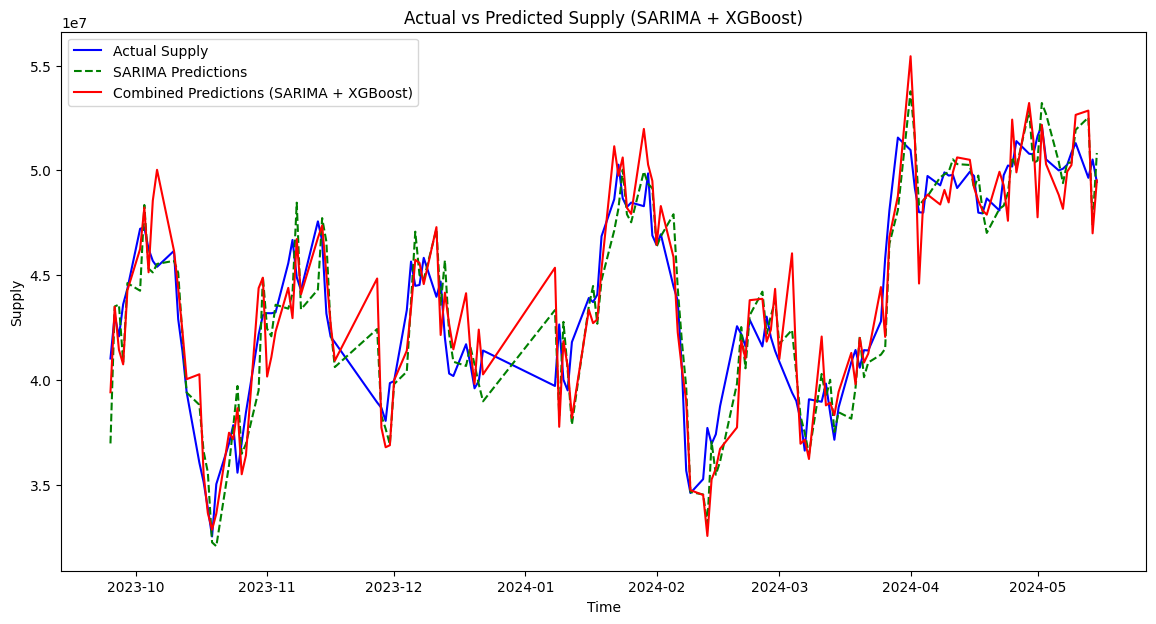

Mean Absolute Error (MAE): 1616805.2588410326
Root Mean Squared Error (RMSE): 2100513.3316186196


In [3]:
# Ensure the 'Date' column is properly set as a datetime index
supply_data['Date'] = pd.to_datetime(supply_data['Date'])  # Convert to datetime
supply_data.set_index('Date', inplace=True)  # Set as index

# Fit SARIMA model
sarima_model = SARIMAX(
    supply_data['Supply'],
    order=(2, 1, 0),
    seasonal_order=(2, 1, 0, 72),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit()

# Generate SARIMA predictions
supply_data['SARIMA_Predicted'] = sarima_result.fittedvalues
supply_data['Residuals'] = supply_data['Supply'] - supply_data['SARIMA_Predicted']

# Feature Engineering for XGBoost
supply_data['day'] = supply_data.index.day
supply_data['month'] = supply_data.index.month
supply_data['year'] = supply_data.index.year
supply_data['day_of_week'] = supply_data.index.dayofweek

# Remove NaN values caused by differencing
supply_data.dropna(inplace=True)

# Train-Test Split
train_size = int(len(supply_data) * 0.8)
train_data = supply_data.iloc[:train_size]
test_data = supply_data.iloc[train_size:]

X_train = train_data[['day', 'month', 'year', 'day_of_week']]
y_train = train_data['Residuals']
X_test = test_data[['day', 'month', 'year', 'day_of_week']]
y_test = test_data['Residuals']

# Train XGBoost on Residuals
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predict Residuals with XGBoost
xgb_residuals_pred = xgb_model.predict(X_test)

# Final Forecast = SARIMA Predictions + XGBoost-Predicted Residuals
sarima_forecast = sarima_result.predict(start=test_data.index[0], end=test_data.index[-1])
final_forecast = sarima_forecast + xgb_residuals_pred

# Evaluate the Combined Model
mae_combined = mean_absolute_error(test_data['Supply'], final_forecast)
rmse_combined = np.sqrt(mean_squared_error(test_data['Supply'], final_forecast))

# Plot Actual vs Predicted
plt.figure(figsize=(14, 7))
plt.plot(test_data['Supply'], label='Actual Supply', color='blue')
plt.plot(sarima_forecast, label='SARIMA Predictions', color='green', linestyle='--')
plt.plot(final_forecast, label='Combined Predictions (SARIMA + XGBoost)', color='red')
plt.title('Actual vs Predicted Supply (SARIMA + XGBoost)')
plt.xlabel('Time')
plt.ylabel('Supply')
plt.legend()
plt.show()

# Print Error Metrics
print(f"Mean Absolute Error (MAE): {mae_combined}")
print(f"Root Mean Squared Error (RMSE): {rmse_combined}")


In [4]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create the model
xgb = XGBRegressor(objective='reg:squarederror')

# Perform grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 8468017672032.853


C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Grid Search
Systematically try combinations of parameter values.
Use GridSearchCV from sklearn:

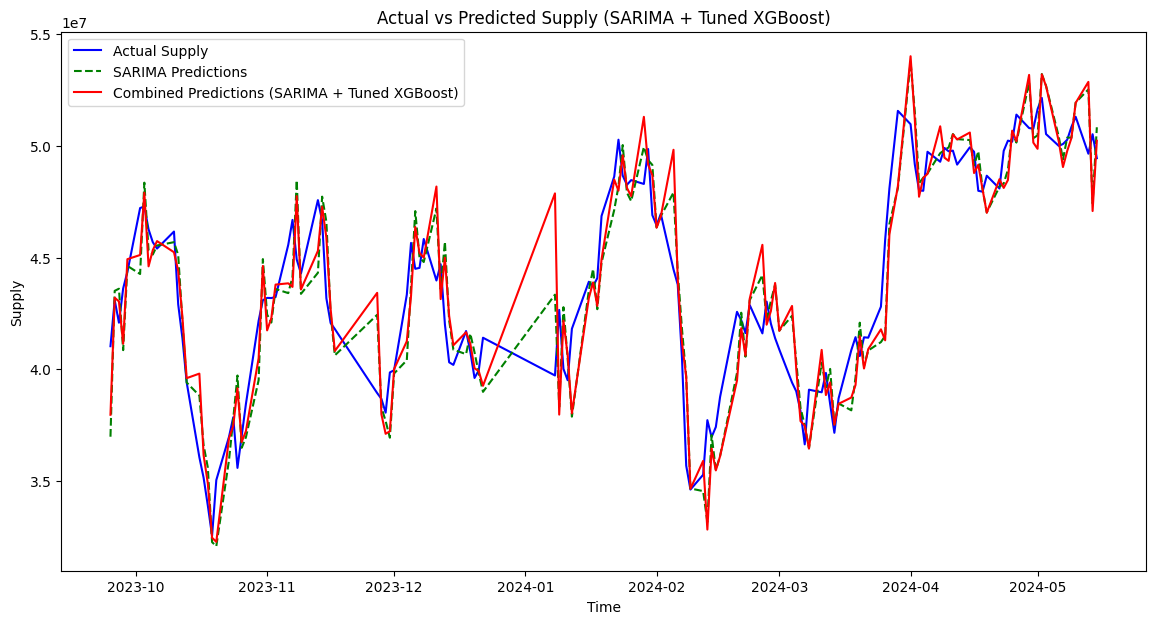

Mean Absolute Error (MAE): 1497144.2811792255
Root Mean Squared Error (RMSE): 1993375.5038824056


In [5]:
# Refit XGBoost with the best parameters from grid search
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_child_weight': 3,
    'n_estimators': 100,
    'subsample': 1.0
}

# Create the model with the best parameters
xgb_best_model = XGBRegressor(objective='reg:squarederror', **best_params)

# Fit the model on training data
xgb_best_model.fit(X_train, y_train)

# Predict residuals on test data
xgb_best_residuals_pred = xgb_best_model.predict(X_test)

# Final Forecast: SARIMA Predictions + XGBoost-Predicted Residuals
sarima_forecast_updated = sarima_result.predict(start=test_data.index[0], end=test_data.index[-1])
final_forecast_updated = sarima_forecast_updated + xgb_best_residuals_pred

# Evaluate the combined model with tuned XGBoost
mae_combined_updated = mean_absolute_error(test_data['Supply'], final_forecast_updated)
rmse_combined_updated = np.sqrt(mean_squared_error(test_data['Supply'], final_forecast_updated))

# Plot Actual vs Predicted
plt.figure(figsize=(14, 7))
plt.plot(test_data['Supply'], label='Actual Supply', color='blue')
plt.plot(sarima_forecast_updated, label='SARIMA Predictions', color='green', linestyle='--')
plt.plot(final_forecast_updated, label='Combined Predictions (SARIMA + Tuned XGBoost)', color='red')
plt.title('Actual vs Predicted Supply (SARIMA + Tuned XGBoost)')
plt.xlabel('Time')
plt.ylabel('Supply')
plt.legend()
plt.show()

# Print Error Metrics
print(f"Mean Absolute Error (MAE): {mae_combined_updated}")
print(f"Root Mean Squared Error (RMSE): {rmse_combined_updated}")


Bayesian Optimization
Uses probabilistic methods to find the best parameters.
Implement using hyperopt or Optuna.

In [6]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.0, 10.0),
        'alpha': trial.suggest_float('alpha', 0.0, 10.0)
    }
    model = XGBRegressor(objective='reg:squarederror', **params)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)


C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-02 23:40:19,946] A new study created in memory with name: no-name-9ee9e109-1800-48f9-bf72-d2672fc7c1f8
[I 2024-12-02 23:40:20,334] Trial 0 finished with value: 10058344555570.256 and parameters: {'learning_rate': 0.07555771233707391, 'n_estimators': 141, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.5951572183823719, 'colsample_bytree': 0.7416802633371471, 'lambda': 1.4951301159674524, 'alpha': 7.633647263285921}. Best is trial 0 with value: 10058344555570.256.
[I 2024-12-02 23:40:20,637] Trial 1 finished with value: 9768854917603.783 and parameters: {'learning_rate': 0.1050217023105311, 'n_estimators': 137, 'max_depth': 9, 'min

Best Parameters: {'learning_rate': 0.010109855014427327, 'n_estimators': 342, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8519163907517967, 'colsample_bytree': 0.6382370112068166, 'lambda': 6.644845844672299, 'alpha': 2.6874312425743727}


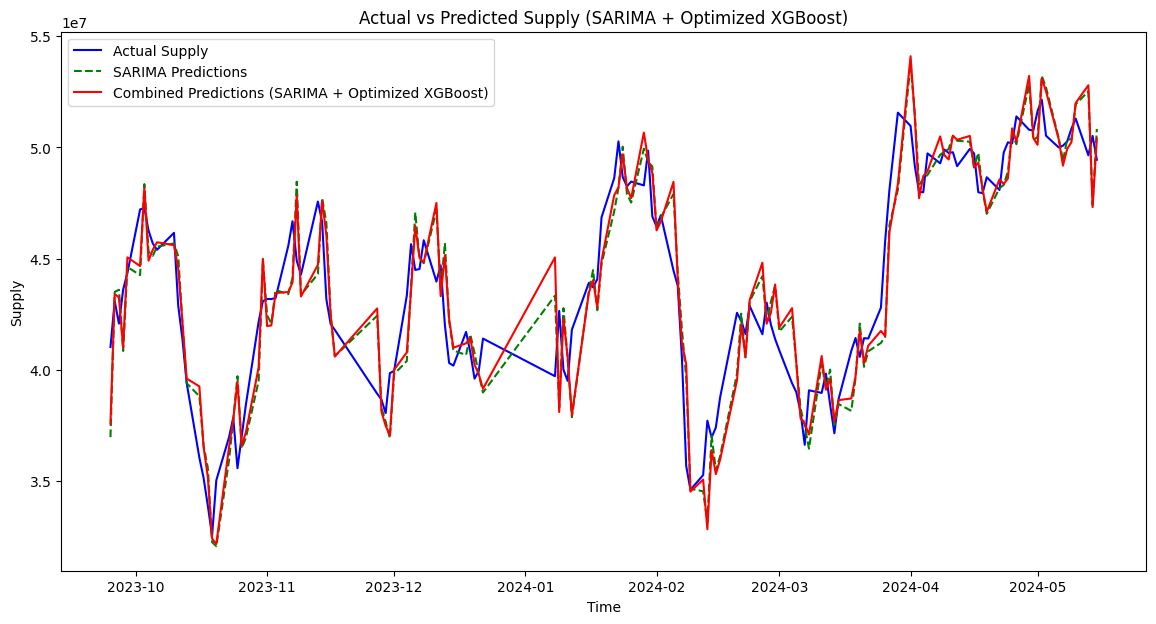

Mean Absolute Error (MAE): 1466116.947558508
Root Mean Squared Error (RMSE): 1886628.507614896


In [7]:
# Refit XGBoost with the best parameters
optimized_params = {
    'learning_rate': 0.011041923165632921,
    'n_estimators': 107,
    'max_depth': 6,
    'min_child_weight': 3,
    'subsample': 0.5954221655366965,
    'colsample_bytree': 0.6483532688261415,
    'lambda': 5.411090146147797,
    'alpha': 5.870979610207895
}

# Train the XGBoost model with optimized parameters
xgb_optimized = XGBRegressor(objective='reg:squarederror', **optimized_params)
xgb_optimized.fit(X_train, y_train)

# Predict residuals with the optimized XGBoost model
xgb_residuals_optimized = xgb_optimized.predict(X_test)

# Combine SARIMA predictions with optimized XGBoost residuals
final_forecast_optimized = sarima_forecast + xgb_residuals_optimized

# Evaluate the Combined Model
mae_optimized = mean_absolute_error(test_data['Supply'], final_forecast_optimized)
rmse_optimized = np.sqrt(mean_squared_error(test_data['Supply'], final_forecast_optimized))

# Plot Actual vs Predicted with optimized model
plt.figure(figsize=(14, 7))
plt.plot(test_data['Supply'], label='Actual Supply', color='blue')
plt.plot(sarima_forecast, label='SARIMA Predictions', color='green', linestyle='--')
plt.plot(final_forecast_optimized, label='Combined Predictions (SARIMA + Optimized XGBoost)', color='red')
plt.title('Actual vs Predicted Supply (SARIMA + Optimized XGBoost)')
plt.xlabel('Time')
plt.ylabel('Supply')
plt.legend()
plt.show()

# Print Error Metrics
print(f"Mean Absolute Error (MAE): {mae_optimized}")
print(f"Root Mean Squared Error (RMSE): {rmse_optimized}")
